Randomization inference is probably the way we want to go in order to handle very skewed distributions of continuous metrics.  We need to be able to supply the following functionality:

1. Generic randomization inference for any scalar test statistic

2. A selection of pre-built test statistics along with documentation about what they mean and when you might want to use them

3. A method for doing hypothetical assignment, or supplying your own function (we may want to scale this up at some point to have some pre-built functions). We'll focus on binary assignment for now (i.e. only two variants), and we'll work to generalize this later.

4. Power analysis. This is relatively easy, but we need a way to do run time estimations as well

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy 

from matplotlib import style
from tqdm.auto import tqdm

In [103]:
# Additional imports 
from functools import partial
import math
import itertools
from time import gmtime, strftime

In [3]:
# Set pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

In [4]:
# Set plot style
style.use("fivethirtyeight")

In [5]:
# Initialize tqdm for pandas
tqdm.pandas()

In [6]:
# Example dataset: from https://www.franciscoyira.com/post/randomization-inference-causal-mixtape/

In [7]:
name_list = ['Andy', 'Ben', 'Chad', 'Daniel', 'Edith', 'Frank', 'George', 'Hank']
d_list = [1,1,1,1,0,0,0,0]
y_list = [10,5,16,3,5,7,8,10]
y0_list = [np.nan, np.nan, np.nan, np.nan, 5, 7, 8, 10]
y1_list = [10,5,16,3,np.nan,np.nan,np.nan,np.nan]
id_unit_list = [1,2,3,4,5,6,7,8]

In [8]:
df = pd.DataFrame()
df['name'] = name_list
df['d'] = d_list
df['y'] = y_list
df['y0'] = y0_list
df['y1'] = y1_list
df['id_unit'] = id_unit_list

In [9]:
df

,name,d,y,y0,y1,id_unit
0,Andy,1,10,NaN,10.0,1
1,Ben,1,5,NaN,5.0,2
2,Chad,1,16,NaN,16.0,3
3,Daniel,1,3,NaN,3.0,4
4,Edith,0,5,5.0,NaN,5
5,Frank,0,7,7.0,NaN,6
6,George,0,8,8.0,NaN,7
7,Hank,0,10,10.0,NaN,8


In [10]:
df.head()

,name,d,y,y0,y1,id_unit
0,Andy,1,10,NaN,10.0,1
1,Ben,1,5,NaN,5.0,2
2,Chad,1,16,NaN,16.0,3
3,Daniel,1,3,NaN,3.0,4
4,Edith,0,5,5.0,NaN,5


In [11]:
df.to_csv('../../../data/test_data_for_ri.csv', index=False)

In [12]:
t = "d"
val = 1

In [13]:
df.query("d==1")

,name,d,y,y0,y1,id_unit
0,Andy,1,10,NaN,10.0,1
1,Ben,1,5,NaN,5.0,2
2,Chad,1,16,NaN,16.0,3
3,Daniel,1,3,NaN,3.0,4


In [14]:
df.query("{0}==@val".format(t))

,name,d,y,y0,y1,id_unit
0,Andy,1,10,NaN,10.0,1
1,Ben,1,5,NaN,5.0,2
2,Chad,1,16,NaN,16.0,3
3,Daniel,1,3,NaN,3.0,4


In [15]:
def ri_test_statistic_difference_in_means(df, outcome_col, treatment_col, treatment_name, control_name):
    
    sdo = df.query("{0}==@treatment_name".format(treatment_col))[outcome_col].mean(numeric_only=True) - df.query("{0}==@control_name".format(treatment_col))[outcome_col].mean(numeric_only=True)

    return sdo

In [176]:
def ri_test_statistic_difference_in_ks(df, outcome_col, treatment_col, treatment_name, control_name, alternative='two-sided'):
    
    ks_ = stats.ks_2samp(df.query("{0}==@treatment_name".format(treatment_col))[outcome_col].values, df.query("{0}==@control_name".format(treatment_col))[outcome_col].values, alternative=alternative)
    
    return ks_.statistic

In [17]:
def ri_test_statistic_difference_in_quantiles(df, outcome_col, treatment_col, treatment_name, control_name, quantile=0.5):
    
    q_diff = df.query("{0}==@treatment_name".format(treatment_col))[outcome_col].quantile(q=quantile) - df.query("{0}==@control_name".format(treatment_col))[outcome_col].quantile(q=quantile)
    
    return q_diff

The steps here for analyzing experimental data are:

1. Choose a sharp null

2. Pick a test statistic

3. Select randomization procedure 
    
    a. Run the permutations

4. Get the p-values by comparing to the true statistic with the simulated distribution

5. Calculate confidence intervals

For power analysis:

1. Choose a sharp null

2. Pick a test statistic

3. Select the desired power and confidence level

4. compute mme

We'll need to run sample size estimation as well, so probably we'll need to sample the historical data and run calculations from there. Then tie the sample sizes back to run times

In [18]:
def get_all_combinations(size, treatment_probability):
    all_combs = list(itertools.combinations(list(range(size)), int(size*treatment_probability)))
    hypothetical_assignments = {}
    for i, comb in enumerate(all_combs):
        assignment_vector = np.zeros(size)
        assignment_vector[list(comb)] = 1
        hypothetical_assignments[i] = tuple(assignment_vector)
    
    return hypothetical_assignments

In [19]:
def make_hypothetical_assignment(size, treatment_assignment_probability, num_perms=1000):
    assert treatment_assignment_probability > 0 and treatment_assignment_probability < 1, "Treatment assignment probabilities must be great than 0 and less than 1. Received {0}".format(treatment_assignment_probability)
    
    # set the random seed
    np.random.seed()
    
    try:
        n_combs = math.comb(size, int(size*treatment_probability))
    except ValueError:
        n_combs = np.inf
    
    print(n_combs)
    if n_combs <= num_perms:
        print('this happened')
        # Just get all possible assignment combinations
        assignment_dict = get_all_combinations(size, treatment_probability)
    else:
        assignment_dict = {}
        while len(assignment_dict) < num_perms: # I'm a little worried that this is going to run forever
            assignment_tuple = tuple(stats.binom.rvs(n=1, p=treatment_assignment_probability, size=size))
            hashed_key = hash(assignment_tuple)
            if hashed_key not in assignment_dict:
                assignment_dict[hashed_key] = assignment_tuple
    
    return assignment_dict

In [20]:
# Now we need a function to calculate the test statistic
# Effectively this needs to replace
# def make_hypothetical_assignments(df_, treatment_assignment_probability):
#     # This is too simple. We need to actually sample from the space of assignment vectors without replacement. 
#     assert treatment_assignment_probability > 0 and treatment_assignment_probability < 1, "Treatment assignment probabilities must be great than 0 and less than 1. Received {0}".format(treatment_assignment_probability)

#     # set the random seed
#     np.random.seed()

#     df_['ri_in_treatment'] = stats.binom.rvs(n=1, p=treatment_assignment_probability, size=df_.shape[0])

#     return df_
# AND
# def run_randomization_inference(self, df, test_statistic_function, treatment_assignment_probability):

#     df_ = self.make_hypothetical_assignments(df_=df, treatment_assignment_probability=treatment_assignment_probability)

#     stat_ = test_statistic_function(df=df_, outcome_col='outcome_sharp_null', treatment_col='ri_in_treatment', treatment_name=1, control_name=0)

#     return stat_
def calculate_test_statistic(df, test_statistic_function, assignment_dict):
    sim_dict = {}
    for i, assignment_tuple in tqdm(enumerate(assignment_dict.values())):
        df_['ri_in_treatment'] = assignment_tuple
        stat_ = test_statistic_function(df=df_, outcome_col='outcome_sharp_null', treatment_col='ri_in_treatment', treatment_name=1, control_name=0)
        sim_dict[i] = stat_
    
    return sim_dict

In [224]:
class RandomizationInference:
    
    def __init__(self):
        
        self._supported_test_statistics = {'difference_in_means': ri_test_statistic_difference_in_means, 
                              'difference_in_percentiles': ri_test_statistic_difference_in_quantiles, 
                              'difference_in_ks_statistic': ri_test_statistic_difference_in_ks}
        # self._supported_ci_methods = ['percentile', 'pivotal']
        self.df_sims = None
        self.observed_test_statistic = None
        self.p_val = None
        self.ci = None

        
    @staticmethod
    def sharp_null(df_, sharp_null_type, sharp_null_value, outcome_column_name):
        
        if sharp_null_type == 'additive':
            df_['outcome_sharp_null'] = df_[outcome_column_name] + sharp_null_value
        else:
            df_['outcome_sharp_null'] = df_[outcome_column_name] * df_[outcome_column_name] * sharp_null_value
        
        return df_
    
    
    def select_test_statistic(self, test_statistic: dict):
        
        if type(test_statistic['function']) == str:
            assert test_statistic['function'] in self._supported_test_statistics, "test statistic {0} is not currently support. Please select from {1} for implement your own function".format(test_statstic['function'], self._supported_test_statistics)
            test_statistic['function'] = self._supported_test_statistics[test_statistic['function']]
        else:
            assert callable(test_statistic['function']), "supplied custom test statistic {0} is neither a supported type nor a function".format(test_statstic['function'])
        
        if test_statistic['params'] is None:
            test_statistic['params'] = {}
        else:
            assert type(test_statistic['params']) == dict, "Please pass a dictionary of parameters to your test statistic function. The keys should be the parameter names and the values the parameter values."
        
        test_statistic_function = partial(test_statistic['function'], **test_statistic['params'])
        
        return test_statistic_function

    
#     @staticmethod
#     def make_hypothetical_assignments(df_, treatment_assignment_probability):
#         # This is too simple. We need to actually sample from the space of assignment vectors without replacement. 
#         assert treatment_assignment_probability > 0 and treatment_assignment_probability < 1, "Treatment assignment probabilities must be great than 0 and less than 1. Received {0}".format(treatment_assignment_probability)
        
#         # set the random seed
#         np.random.seed()
        
#         df_['ri_in_treatment'] = stats.binom.rvs(n=1, p=treatment_assignment_probability, size=df_.shape[0])
        
#         return df_

    @staticmethod 
    def calculate_test_statistic(df_, test_statistic_function, assignments):
        
        df_['ri_in_treatment'] = assignments
        # Handle numeric instability here
        stat_ = np.round(test_statistic_function(df=df_, outcome_col='outcome_sharp_null', treatment_col='ri_in_treatment', treatment_name=1, control_name=0), 10)
        return stat_
    

    @staticmethod
    def get_all_combinations(size, treatment_probability):
        
        all_combs = list(itertools.combinations(list(range(size)), int(size*treatment_probability)))
        hypothetical_assignments = {}
        for i, comb in enumerate(all_combs):
            assignment_vector = np.zeros(size)
            assignment_vector[list(comb)] = 1
            hypothetical_assignments[i] = tuple(assignment_vector)

        return hypothetical_assignments
    
    
    def make_hypothetical_assignment(self, df_, treatment_assignment_probability, test_statistic_function, sample_with_replacement, num_perms=1000):
        
        sim_dict = {}
            
        # set the random seed
        np.random.seed()

        try:
            n_combs = math.comb(df_.shape[0], int(df_.shape[0]*treatment_assignment_probability))
        except ValueError:
            n_combs = np.inf

        if n_combs <= num_perms:
            print('Found {0} distinct assignment combinations. All combinations will be simulated.')
            # Just get all possible assignment combinations. This should be small enough to handle in memory
            assignment_dict = self.get_all_combinations(size=df_.shape[0], treatment_probability=treatment_assignment_probability)
            for i, comb in tqdm(assignment_dict.items()):
                sim_dict[i] = self.calculate_test_statistic(df_=df_, test_statistic_function=test_statistic_function, assignments=comb)
        else:
            print('Number of distinct assignment combinations practically too large. Running {0} simulated permutations'.format(num_perms))
            if not sample_with_replacement:
                assignment_dict = {}
                i = 0
                pbar = tqdm(total=num_perms)
                # TODO: Make this faster
                # Actually, let's make it optional
                while len(assignment_dict) < num_perms: # I'm a little worried that this is going to run forever 
                    assignment_tuple = tuple(stats.binom.rvs(n=1, p=treatment_assignment_probability, size=df_.shape[0]))
                    hashed_key = hash(assignment_tuple)
                    if hashed_key not in assignment_dict:
                        assignment_dict[hashed_key] = hashed_key
                        sim_dict[i] = self.calculate_test_statistic(df_=df_, test_statistic_function=test_statistic_function, assignments=assignment_tuple)
                        i += 1
                        pbar.update(1)
                pbar.close()
            else:
                for i in tqdm(range(num_perms)):
                    assignment_list = stats.binom.rvs(n=1, p=treatment_assignment_probability, size=df_.shape[0])
                    sim_dict[i] = self.calculate_test_statistic(df_=df_, test_statistic_function=test_statistic_function, assignments=assignment_list)
                    
        return sim_dict
    
    
#     @staticmethod
#     def calculate_test_statistic(df_, test_statistic_function, assignment_dict):
        
#         sim_dict = {}
#         for i, assignment_tuple in enumerate(tqdm(assignment_dict.values())):
#             df_['ri_in_treatment'] = assignment_tuple
#             # Handle numeric instability here
#             stat_ = np.round(test_statistic_function(df=df_, outcome_col='outcome_sharp_null', treatment_col='ri_in_treatment', treatment_name=1, control_name=0), 10)
#             sim_dict[i] = stat_

#         return sim_dict
    
    
    def p_value(self, alternative):
        
       #  df_ = self.df_sims.copy()
        
        if not self.observed_test_statistic in self.df_sims['test_statistic'].values:
            add_row = pd.DataFrame({"permutation": [-1], "test_statistic": self.observed_test_statistic})
            self.df_sims = pd.concat([add_row, self.df_sims])
            observed_perm = -1
        else:
            observed_perm = self.df_sims.loc[(self.df_sims['test_statistic'] == self.observed_test_statistic)]['permutation'].values[0]
        
        if alternative == 'two-sided':
            self.df_sims['rank_column'] = np.abs(self.df_sims['test_statistic'])
        else:
            self.df_sims['rank_column'] = self.df_sims['test_statistic']
        
        self.df_sims['rank'] = self.df_sims['rank_column'].rank(method='max', ascending=False)
        
        p_value = self.df_sims.query("permutation==@observed_perm")['rank'].values[0] / self.df_sims.shape[0]
        
        return p_value
    
    
    def get_ci(self, confidence, alternative):
        
        # TODO: This needs to be totally revamped. This is way too primitive of an approach. 
        # assert method in ['percentile', 'pivotal'], "Confidence interval calculation method {0} is not supported. Currently supported methods are: {1}".format(method, self._supported_ci_methods)
        # We'll only support the basic method for now (this is actually implemented in scipy https://github.com/scipy/scipy/blob/v1.12.0/scipy/stats/_resampling.py#L279-L660)
        
        alpha = 1 - confidence
        df_ = self.df_sims.copy()
        df_ = df_.query("permutation != -1")
        
        if alternative == 'two-sided':
            alpha = ((1 - confidence)) / 2
        else:
            alpha = 1 - confidence
        
        interval = alpha, 1 - alpha
        
        # Calculate the percentiles
        ci_low = np.percentile(df_['test_statistic'].values, interval[0]*100)
        ci_high = np.percentile(df_['test_statistic'].values, interval[1]*100)
        
        ci_low, ci_high = 2 * self.observed_test_statistic - ci_high, 2 * self.observed_test_statistic - ci_low
        
        if alternative == 'less':
            ci_low = np.full_like(ci_low, -np.inf)
        elif alternative == 'greater':
            ci_high = np.full_like(ci_high, np.inf)
        
        ci_ = np.array([ci_low, ci_high])
        
        return ci_
        
#         if method == 'percentile':
#             # Not sure if this is actually right. Should probably default to using the pivotal method in any case
#             ci_low = np.percentile(self.df_sims['test_statistic'].values, 100 * (alpha / 2.)) + self.observed_test_statistic
#             ci_high = np.percentile(self.df_sims['test_statistic'].values, 100 * (1 - alpha / 2.)) + self.observed_test_statistic
#         else:
#             ci_low = 2 * self.observed_test_statistic - np.percentile(self.df_sims['test_statistic'].values, 100 * (1 - alpha / 2.))
#             ci_high = 2 * self.observed_test_statistic - np.percentile(self.df_sims['test_statistic'].values, 100 * (alpha / 2.))
        
#         ci_ = np.array([ci_low, ci_high])
    
#         return ci_
    
    def plot_and_output_results(self, confidence, alternative, test_stat_name, filename, output_path):

        df_for_ranking = self.df_sims.copy()
        df_for_ranking['rejection'] = df_for_ranking['rank'] / df_for_ranking.shape[0]
        rejection_edge = df_for_ranking.loc[(df_for_ranking['rejection'] <= (1 - confidence))]['rejection'].max()
        rejection_edge_values = df_for_ranking.loc[(df_for_ranking['rejection'] == rejection_edge)]
        
        fig, ax = plt.subplots(figsize=(10,8))
        sns.histplot(data=self.df_sims, x='test_statistic', fill=True, ax=ax, kde=True, label='Null distribution')
        kde_x, kde_y = ax.lines[0].get_data()

        p0 = plt.axvline(x=self.observed_test_statistic, color='green', linestyle='--', label='Observed test statistic: {0})'.format(np.round(self.observed_test_statistic, 2)))

        # ax.fill_between(kde_x, kde_y, where=(kde_x > pos_gmv_experiment.ci[0]) | (kde_x > pos_gmv_experiment.ci[1]), interpolate=True, color='#EF9A9A', alpha=0.5)
        # ax.fill_between(kde_x, kde_y, where=(kde_x > self.ci[0]) | (kde_x > self.ci[1]), interpolate=True, alpha=0.5, label="{0}% confidence interval".format(int(confidence*100)))
        # Fill in the area where the test statistic is more extreme than the observed 
        if alternative == 'two-sided':
            ax.fill_between(kde_x, kde_y, where=(kde_x >= rejection_edge_values['test_statistic'].max()) | (kde_x <= rejection_edge_values['test_statistic'].min()), interpolate=True, alpha=0.5, label="Values more extreme than test statistic")
        elif alternative == 'less':
            ax.fill_between(kde_x, kde_y, where=(kde_x <= rejection_edge_values['test_statistic'].min()), interpolate=True, alpha=0.5, label="Values more extreme than test statistic")
        elif alternative == 'greater':
            ax.fill_between(kde_x, kde_y, where=(kde_x >= rejection_edge_values['test_statistic'].max()), interpolate=True, alpha=0.5, label="Values more extreme than test statistic")
        
        ax.set_title('Distribution of test statistic under null. p-value: {0}'.format(np.round(self.p_val, 3)), fontsize=18)
        ax.set_xlabel("{0}".format(test_stat_name), fontsize=16)
        plt.legend(bbox_to_anchor=(0.7, -0.1))

        if filename is None:
            current_time = strftime('%Y-%m-%d_%H%M%S', gmtime())
            filename = 'experimental_analysis_{0}.png'.format(current_time)
        else:
            if not filename.endswith('.png'):
                filename = filename.split('.')[0] + '.png'
        
        if output_path is None:
            output_path = os.getcwd()
        
        save_path = os.path.join(output_path, filename)
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  


#     def plot_and_output_results(self, confidence, test_stat_name, filename, output_path):

#         fig, ax = plt.subplots(figsize=(10,8))
#         sns.histplot(data=self.df_sims, x='test_statistic', fill=True, ax=ax, kde=True, label='Null distribution')
#         kde_x, kde_y = ax.lines[0].get_data()

#         p0 = plt.axvline(x=self.observed_test_statistic, color='green', linestyle='--', label='Observed test statistic: {0} ({1}% CI: {2} - {3})'.format(np.round(self.observed_test_statistic, 2), int(confidence*100), np.round(self.ci[0], 2), np.round(self.ci[1], 2)))

#         # ax.fill_between(kde_x, kde_y, where=(kde_x > pos_gmv_experiment.ci[0]) | (kde_x > pos_gmv_experiment.ci[1]), interpolate=True, color='#EF9A9A', alpha=0.5)
#         ax.fill_between(kde_x, kde_y, where=(kde_x > self.ci[0]) | (kde_x > self.ci[1]), interpolate=True, alpha=0.5, label="{0}% confidence interval".format(int(confidence*100)))


#         ax.set_title('Distribution of test statistic under null. p-value: {0}'.format(np.round(self.p_val, 3)), fontsize=18)
#         ax.set_xlabel("{0}".format(test_stat_name), fontsize=16)
#         plt.legend(bbox_to_anchor=(0.7, -0.1))

#         if filename is None:
#             current_time = strftime('%Y-%m-%d_%H%M%S', gmtime())
#             filename = 'experimental_analysis_{0}.png'.format(current_time)
#         else:
#             if not filename.endswith('.png'):
#                 filename = filename.split('.')[0] + '.png'
        
#         if output_path is None:
#             output_path = os.getcwd()
        
#         save_path = os.path.join(output_path, filename)
        
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    
    
    def run_randomization_inference(self, df_, test_statistic_function, treatment_assignment_probability, sample_with_replacement, num_perms=1000):
        
        assert treatment_assignment_probability > 0 and treatment_assignment_probability < 1, "Treatment assignment probabilities must be great than 0 and less than 1. Received {0}".format(treatment_assignment_probability)
        
        # This is not efficient. This will eat a lot of memory when the number of permutations goes above a few thousand
        sim_dict= self.make_hypothetical_assignment(df_=df_, treatment_assignment_probability=treatment_assignment_probability, test_statistic_function=test_statistic_function, num_perms=num_perms, sample_with_replacement=sample_with_replacement)
        
        # sim_dict = self.calculate_test_statistic(df_=df_, test_statistic_function=test_statistic_function, assignment_dict=assignment_dict)
        
        return sim_dict
    
    
    def experimental_analysis(self, df, sharp_null_type='additive', sharp_null_value=0, test_statistic={'function': 'difference_in_means', 'params': None}, treatment_assignment_probability=0.5, outcome_column_name='y', treatment_column_name='d', treatment_name=1, control_name=0, num_permutations=1000, alternative='two-sided', confidence=0.95, sample_with_replacement=False, filename=None, output_path=None):
        
        assert sharp_null_type in ['additive', 'multiplicative'], "only additive or multiplicative sharp nulls are supported. Received {0}".format(sharp_null_type)
        
        assert type(num_permutations) == int, "Only an interger number of permutations is possible. Received {0}".format(num_permutations)
        
        assert alternative in ['two-sided', 'less', 'greater'], "Only {0} alternatives are supported. Received {0}".format(alternative)
        
        # Copy the input DataFrame so that we don't modify the original data in_place
        df_ = df.copy()
        
        # Save the input test statistic name if it's a string
        if type(test_statistic['function']) == str:
            test_stat_name = test_statistic['function'].replace('_', ' ')
        else:
            test_stat_name = 'custom test statistic'
        
        # Step 1: implement the selected sharp null
        df_ = self.sharp_null(df_=df_, sharp_null_type=sharp_null_type, sharp_null_value=sharp_null_value, outcome_column_name=outcome_column_name)
        
        # Step 2: pick a test statistic. We have a list of pre-built ones, otherwise a function must be supplied
        # This function must consume a DataFrame and return a single scalar value
        test_statistic_function = self.select_test_statistic(test_statistic=test_statistic)
        
        # Step 3: Select a randomization proceedure. 
        # Currently this only supports random assignment via coin flip. The probability of being in the treatment group is customizable
        # Also run the simulations
        # print('Running {0} permutations'.format(num_permutations))
        # sim_dict = {i: self.run_randomization_inference(df=df_, test_statistic_function=test_statistic_function, treatment_assignment_probability=treatment_assignment_probability) for i in tqdm(range(num_permutations))}
        print('Running randomization inference...')
        sim_dict = self.run_randomization_inference(df_=df_, test_statistic_function=test_statistic_function, treatment_assignment_probability=treatment_assignment_probability, num_perms=num_permutations, sample_with_replacement=sample_with_replacement)
        
        self.df_sims = pd.DataFrame.from_dict(sim_dict, orient='index')
        self.df_sims = self.df_sims.reset_index()
        self.df_sims.columns = ['permutation', 'test_statistic']
    
        # Step 4: calculate p-values
        # First, calculate the observed statistic difference
        self.observed_test_statistic = test_statistic_function(df=df_, outcome_col=outcome_column_name, treatment_col=treatment_column_name, treatment_name=treatment_name, control_name=control_name)

        self.p_val = self.p_value(alternative=alternative)
        
        # Step 5: calculate confidence interval. This is the CI of the test statistic under the null
        # self.ci = self.get_ci(confidence=confidence, alternative='two-sided')
        
        # final output. This should be summarized in a plot
        self.plot_and_output_results(confidence=confidence, alternative=alternative, test_stat_name=test_stat_name, filename=filename, output_path=output_path)
        
                

In [225]:
# class RandomizationInference:
    
#     def __init__(self):
        
#         self._supported_test_statistics = {'difference_in_means': ri_test_statistic_difference_in_means, 
#                               'difference_in_percentiles': ri_test_statistic_difference_in_quantiles, 
#                               'difference_in_ks_statistic': ri_test_statistic_difference_in_ks}
#         self.df_sims = None
#         self.observed_test_statistic = None
#         self.p_val = None
#         self.ci = None
#         # self.df = df
#         # self.sharp_null = sharp_null
#         # self.test_statistic = test_statistic
#         # self.outcome_column_name = outcome_column_name
#         # self.treatment_column_name = treatment_column_name
#         # self.treatment_name = treatment_name
#         # self.control_name = control_name
#         # self.num_permutations = num_permutations
        
#     @staticmethod
#     def sharp_null(df_, sharp_null_type, sharp_null_value, outcome_column_name):
        
#         if sharp_null_type == 'additive':
#             df_['outcome_sharp_null'] = df_[outcome_column_name] + sharp_null_value
#         else:
#             df_['outcome_sharp_null'] = df_[outcome_column_name] * df_[outcome_column_name] * sharp_null_value
        
#         return df_
    
    
#     def select_test_statistic(self, test_statistic: dict):
        
#         if type(test_statistic['function']) == str:
#             assert test_statistic['function'] in self._supported_test_statistics, "test statistic {0} is not currently support. Please select from {1} for implement your own function".format(test_statstic['function'], self._supported_test_statistics)
#             test_statistic['function'] = self._supported_test_statistics[test_statistic['function']]
#         else:
#             assert callable(test_statistic['function']), "supplied custom test statistic {0} is neither a supported type nor a function".format(test_statstic['function'])
        
#         if test_statistic['params'] is None:
#             test_statistic['params'] = {}
#         else:
#             assert type(test_statistic['params']) == dict, "Please pass a dictionary of parameters to your test statistic function. The keys should be the parameter names and the values the parameter values."
        
#         test_statistic_function = partial(test_statistic['function'], **test_statistic['params'])
        
#         return test_statistic_function

    
# #     @staticmethod
# #     def make_hypothetical_assignments(df_, treatment_assignment_probability):
# #         # This is too simple. We need to actually sample from the space of assignment vectors without replacement. 
# #         assert treatment_assignment_probability > 0 and treatment_assignment_probability < 1, "Treatment assignment probabilities must be great than 0 and less than 1. Received {0}".format(treatment_assignment_probability)
        
# #         # set the random seed
# #         np.random.seed()
        
# #         df_['ri_in_treatment'] = stats.binom.rvs(n=1, p=treatment_assignment_probability, size=df_.shape[0])
        
# #         return df_

#     @staticmethod
#     def get_all_combinations(size, treatment_probability):
        
#         all_combs = list(itertools.combinations(list(range(size)), int(size*treatment_probability)))
#         hypothetical_assignments = {}
#         for i, comb in enumerate(all_combs):
#             assignment_vector = np.zeros(size)
#             assignment_vector[list(comb)] = 1
#             hypothetical_assignments[i] = tuple(assignment_vector)

#         return hypothetical_assignments
    
    
#     @staticmethod
#     def make_hypothetical_assignment(size, treatment_assignment_probability, num_perms=1000):
        
#         assert treatment_assignment_probability > 0 and treatment_assignment_probability < 1, "Treatment assignment probabilities must be great than 0 and less than 1. Received {0}".format(treatment_assignment_probability)

#         # set the random seed
#         np.random.seed()

#         try:
#             n_combs = math.comb(size, int(size*treatment_probability))
#         except ValueError:
#             n_combs = np.inf

#         if n_combs <= num_perms:
#             print('Found {0} distinct assignment combinations. All combinations will be simulated.')
#             # Just get all possible assignment combinations
#             assignment_dict = get_all_combinations(size, treatment_probability)
#         else:
#             print('Number of distinct assignment combinations practically too large. Running {0} simulated permutations'.format(num_perms))
#             assignment_dict = {}
#             while len(assignment_dict) < num_perms: # I'm a little worried that this is going to run forever
#                 assignment_tuple = tuple(stats.binom.rvs(n=1, p=treatment_assignment_probability, size=size))
#                 hashed_key = hash(assignment_tuple)
#                 if hashed_key not in assignment_dict:
#                     assignment_dict[hashed_key] = assignment_tuple

#         return assignment_dict
    
    
#     @staticmethod
#     def calculate_test_statistic(df_, test_statistic_function, assignment_dict):
        
#         sim_dict = {}
#         for i, assignment_tuple in tqdm(enumerate(assignment_dict.values())):
#             df_['ri_in_treatment'] = assignment_tuple
#             # Handle numeric instability here
#             stat_ = np.round(test_statistic_function(df=df_, outcome_col='outcome_sharp_null', treatment_col='ri_in_treatment', treatment_name=1, control_name=0), 10)
#             sim_dict[i] = stat_

#         return sim_dict
    
    
#     def p_value(self, alternative):
        
#        #  df_ = self.df_sims.copy()
        
#         if not self.observed_test_statistic in self.df_sims['test_statistic'].values:
#             add_row = pd.DataFrame({"permutation": [-1], "test_statistic": self.observed_test_statistic})
#             self.df_sims = pd.concat([add_row, self.df_sims])
#             observed_perm = -1
#         else:
#             observed_perm = self.df_sims.loc[(self.df_sims['test_statistic'] == self.observed_test_statistic)]['permutation'].values[0]
        
#         if alternative == 'two-sided':
#             self.df_sims['rank_column'] = np.abs(self.df_sims['test_statistic'])
#         else:
#             self.df_sims['rank_column'] = self.df_sims['test_statistic']
        
#         self.df_sims['rank'] = self.df_sims['rank_column'].rank(method='max', ascending=False)
        
#         p_value = self.df_sims.query("permutation==@observed_perm")['rank'].values[0] / self.df_sims.shape[0]
        
#         return p_value
    
    
#     def get_ci(self, confidence):

#         ci_low = 100 * (1 - confidence) / 2
#         ci_high = 100 * confidence + ci_low
#         null_ci = np.percentile(self.df_sims['test_statistic'].values, [ci_low, ci_high])
#         ci_ = null_ci + self.observed_test_statistic
    
#         return ci_
    
    
# #     def run_randomization_inference(self, df, test_statistic_function, treatment_assignment_probability):
        
# #         df_ = self.make_hypothetical_assignments(df_=df, treatment_assignment_probability=treatment_assignment_probability)
        
# #         stat_ = test_statistic_function(df=df_, outcome_col='outcome_sharp_null', treatment_col='ri_in_treatment', treatment_name=1, control_name=0)
        
# #         return stat_
    
    
#     def run_randomization_inference(self, df_, test_statistic_function, treatment_assignment_probability, num_perms=1000):
        
#         assignment_dict = self.make_hypothetical_assignment(size=df_.shape[0], treatment_assignment_probability=treatment_assignment_probability, num_perms=num_perms)
        
#         sim_dict = self.calculate_test_statistic(df_=df_, test_statistic_function=test_statistic_function, assignment_dict=assignment_dict)
        
#         return sim_dict
    
    
#     def experimental_analysis(self, df, sharp_null_type='additive', sharp_null_value=0, test_statistic={'function': 'difference_in_means', 'params': None}, treatment_assignment_probability=0.5, outcome_column_name='y', treatment_column_name='d', treatment_name=1, control_name=0, num_permutations=1000, alternative='two-sided', confidence=0.95):
        
#         assert sharp_null_type in ['additive', 'multiplicative'], "only additive or multiplicative sharp nulls are supported. Received {0}".format(sharp_null_type)
        
#         assert type(num_permutations) == int, "Only an interger number of permutations is possible. Received {0}".format(num_permutations)
        
#         assert alternative in ['two-sided', 'less', 'greater'], "Only {0} alternatives are supported. Received {0}".format(alternative)
        
#         # Copy the input DataFrame so that we don't modify the original data in_place
#         df_ = df.copy()
        
#         # Step 1: implement the selected sharp null
#         df_ = self.sharp_null(df_=df_, sharp_null_type=sharp_null_type, sharp_null_value=sharp_null_value, outcome_column_name=outcome_column_name)
        
#         # Step 2: pick a test statistic. We have a list of pre-built ones, otherwise a function must be supplied
#         # This function must consume a DataFrame and return a single scalar value
#         test_statistic_function = self.select_test_statistic(test_statistic=test_statistic)
        
#         # Step 3: Select a randomization proceedure. 
#         # Currently this only supports random assignment via coin flip. The probability of being in the treatment group is customizable
#         # Also run the simulations
#         # print('Running {0} permutations'.format(num_permutations))
#         # sim_dict = {i: self.run_randomization_inference(df=df_, test_statistic_function=test_statistic_function, treatment_assignment_probability=treatment_assignment_probability) for i in tqdm(range(num_permutations))}
#         print('Running randomization inference...')
#         sim_dict = self.run_randomization_inference(df_=df_, test_statistic_function=test_statistic_function, treatment_assignment_probability=treatment_assignment_probability, num_perms=num_permutations)
        
#         self.df_sims = pd.DataFrame.from_dict(sim_dict, orient='index')
#         self.df_sims = self.df_sims.reset_index()
#         self.df_sims.columns = ['permutation', 'test_statistic']
    
#         # Step 4: calculate p-values
#         # First, calculate the observed statistic difference
#         self.observed_test_statistic = test_statistic_function(df=df_, outcome_col=outcome_column_name, treatment_col=treatment_column_name, treatment_name=treatment_name, control_name=control_name)

#         self.p_val = self.p_value(alternative=alternative)
        
#         # Step 5: calculate confidence interval. This is the CI of the test statistic under the null
#         self.ci = self.get_ci(confidence=confidence)
        
#         # final output. This should be summarized in a plot
        
        
                

In [226]:
test_run = RandomizationInference()

Running randomization inference...
Found {0} distinct assignment combinations. All combinations will be simulated.


  0%|          | 0/70 [00:00<?, ?it/s]

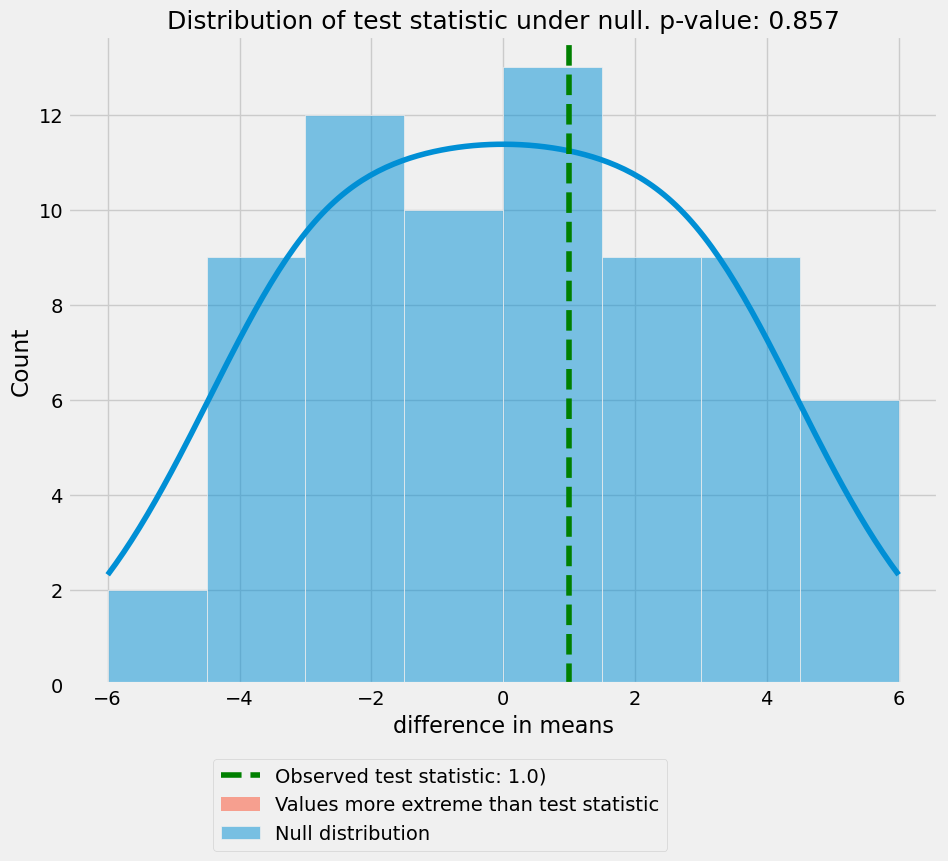

In [227]:
test_run.experimental_analysis(df=df, 
                               sharp_null_type='additive', 
                               sharp_null_value=0, 
                               test_statistic={'function': 'difference_in_means', 'params': None}, 
                               treatment_assignment_probability=0.5, 
                               outcome_column_name='y', 
                               treatment_column_name='d', 
                               treatment_name=1, 
                               control_name=0, 
                               num_permutations=1000, 
                               alternative='two-sided', 
                               confidence=0.95, 
                               sample_with_replacement=True,
                              )

In [207]:
test_run.df_sims.head()

,permutation,test_statistic,rank_column,rank
0,0,1.0,1.0,60.0
1,1,2.0,2.0,46.0
2,2,3.0,3.0,30.0
3,3,3.5,3.5,22.0
4,4,4.5,4.5,12.0


In [209]:
df_rank = test_run.df_sims.copy()

In [210]:
df_rank['rejection'] = df_rank['rank'] / df_rank.shape[0]

In [216]:
rejection_edge = df_rank.loc[(df_rank['rejection'] <= (1 - confidence))]['rejection'].max()
rejection_edge_values = df_rank.loc[(df_rank['rejection'] == rejection_edge)]

In [217]:
rejection_edge_values

,permutation,test_statistic,rank_column,rank,rejection
24,24,6.0,6.0,2.0,0.028571
45,45,-6.0,6.0,2.0,0.028571


In [214]:
1 - confidence

0.050000000000000044

In [170]:
test_run.p_val

0.8571428571428571

In [171]:
test_run.observed_test_statistic

1.0

In [172]:
test_run.df_sims.head()

,permutation,test_statistic,rank_column,rank
0,0,1.0,1.0,60.0
1,1,2.0,2.0,46.0
2,2,3.0,3.0,30.0
3,3,3.5,3.5,22.0
4,4,4.5,4.5,12.0


In [173]:
test_run.ci

array([-2.775,  6.775])

In [185]:
test_run_ks = RandomizationInference()

Running randomization inference...
Found {0} distinct assignment combinations. All combinations will be simulated.


  0%|          | 0/70 [00:00<?, ?it/s]

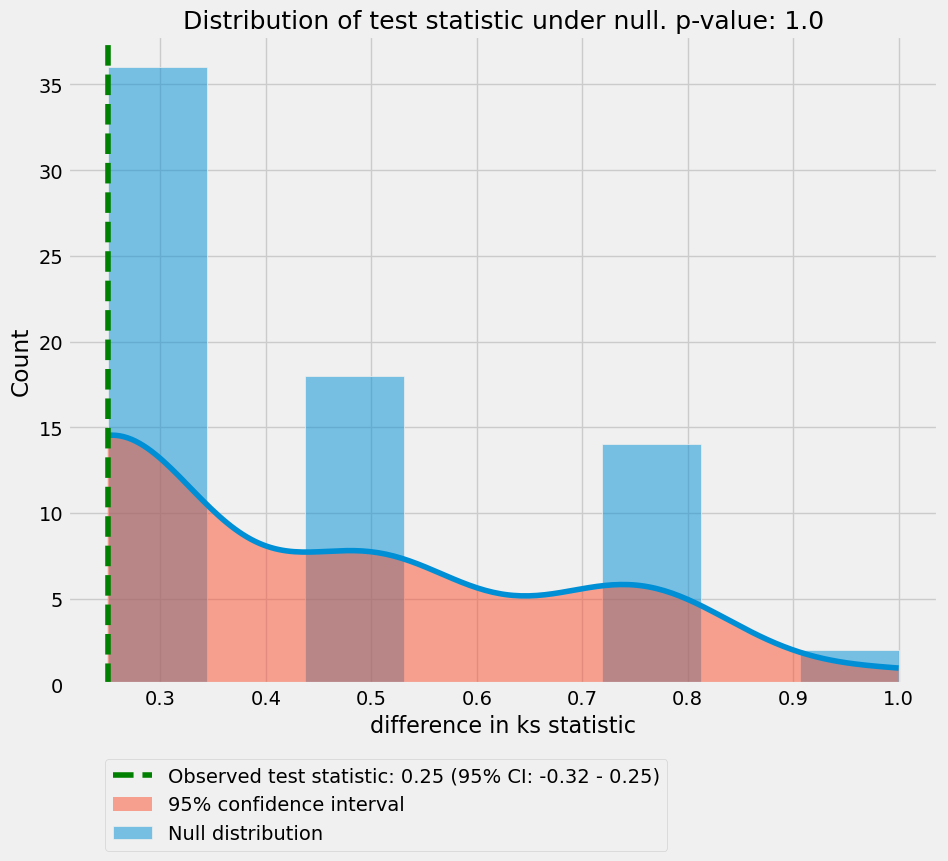

In [186]:
test_run_ks.experimental_analysis(df=df, 
                               sharp_null_type='additive', 
                               sharp_null_value=0, 
                               test_statistic={'function': 'difference_in_ks_statistic', 'params': None}, 
                               treatment_assignment_probability=0.5, 
                               outcome_column_name='y', 
                               treatment_column_name='d', 
                               treatment_name=1, 
                               control_name=0, 
                               num_permutations=1000, 
                               alternative='two-sided', 
                               confidence=0.95, 
                               sample_with_replacement=True,
                              )

In [187]:
test_run_ks.observed_test_statistic

0.25

In [188]:
test_run_ks.ci

array([-0.31875,  0.25   ])

In [189]:
test_run_ks.p_val

1.0

In [191]:
# Well ok, I mean this is such a small sample, this could be all wacky. Let's try a median test and a 75th percentile test
test_run_median = RandomizationInference()

Running randomization inference...
Found {0} distinct assignment combinations. All combinations will be simulated.


  0%|          | 0/70 [00:00<?, ?it/s]

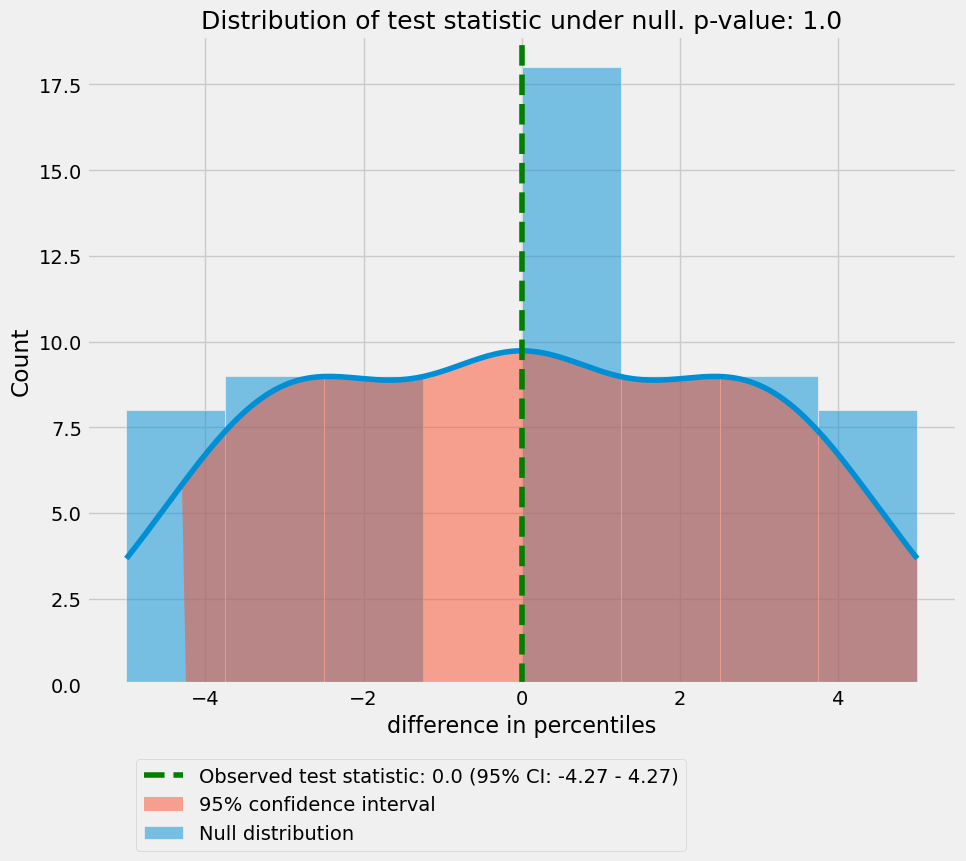

In [193]:
test_run_median.experimental_analysis(df=df, 
                               sharp_null_type='additive', 
                               sharp_null_value=0, 
                               test_statistic={'function': 'difference_in_percentiles', 'params': {'quantile': 0.5}}, 
                               treatment_assignment_probability=0.5, 
                               outcome_column_name='y', 
                               treatment_column_name='d', 
                               treatment_name=1, 
                               control_name=0, 
                               num_permutations=1000, 
                               alternative='two-sided', 
                               confidence=0.95, 
                               sample_with_replacement=True,
                              )

In [194]:
test_run_75 = RandomizationInference()

Running randomization inference...
Found {0} distinct assignment combinations. All combinations will be simulated.


  0%|          | 0/70 [00:00<?, ?it/s]

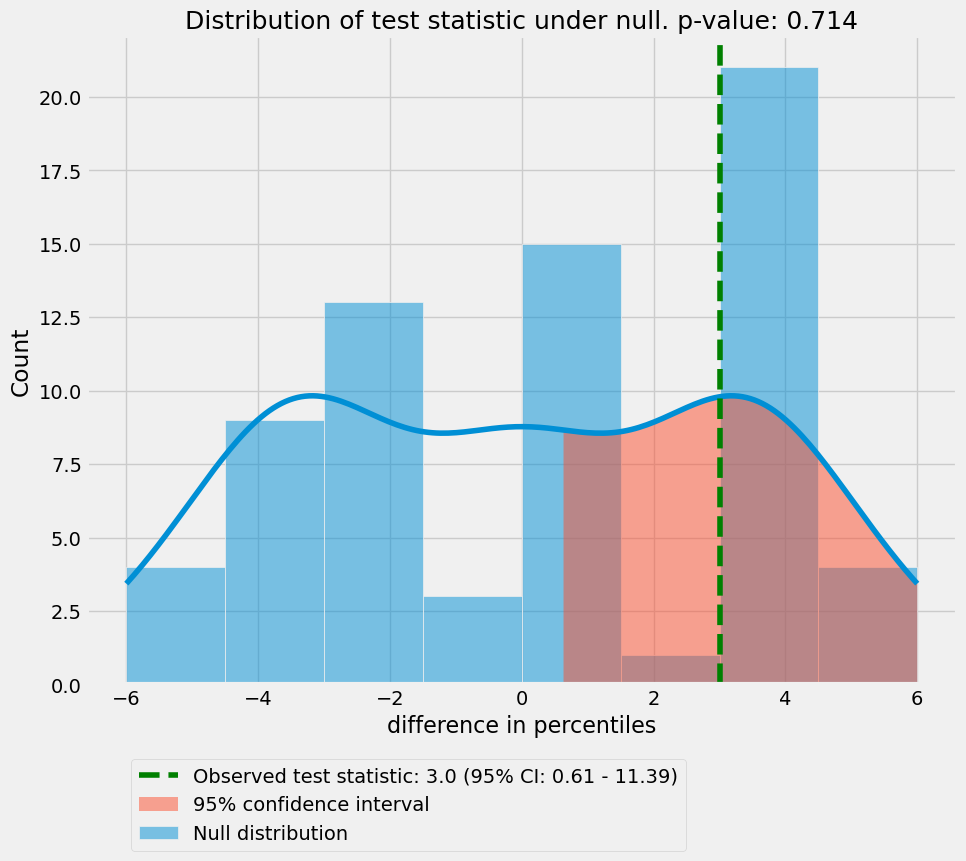

In [195]:
test_run_median.experimental_analysis(df=df, 
                               sharp_null_type='additive', 
                               sharp_null_value=0, 
                               test_statistic={'function': 'difference_in_percentiles', 'params': {'quantile': 0.75}}, 
                               treatment_assignment_probability=0.5, 
                               outcome_column_name='y', 
                               treatment_column_name='d', 
                               treatment_name=1, 
                               control_name=0, 
                               num_permutations=1000, 
                               alternative='two-sided', 
                               confidence=0.95, 
                               sample_with_replacement=True,
                              )

In [196]:
test_run_90 = RandomizationInference()

Running randomization inference...
Found {0} distinct assignment combinations. All combinations will be simulated.


  0%|          | 0/70 [00:00<?, ?it/s]

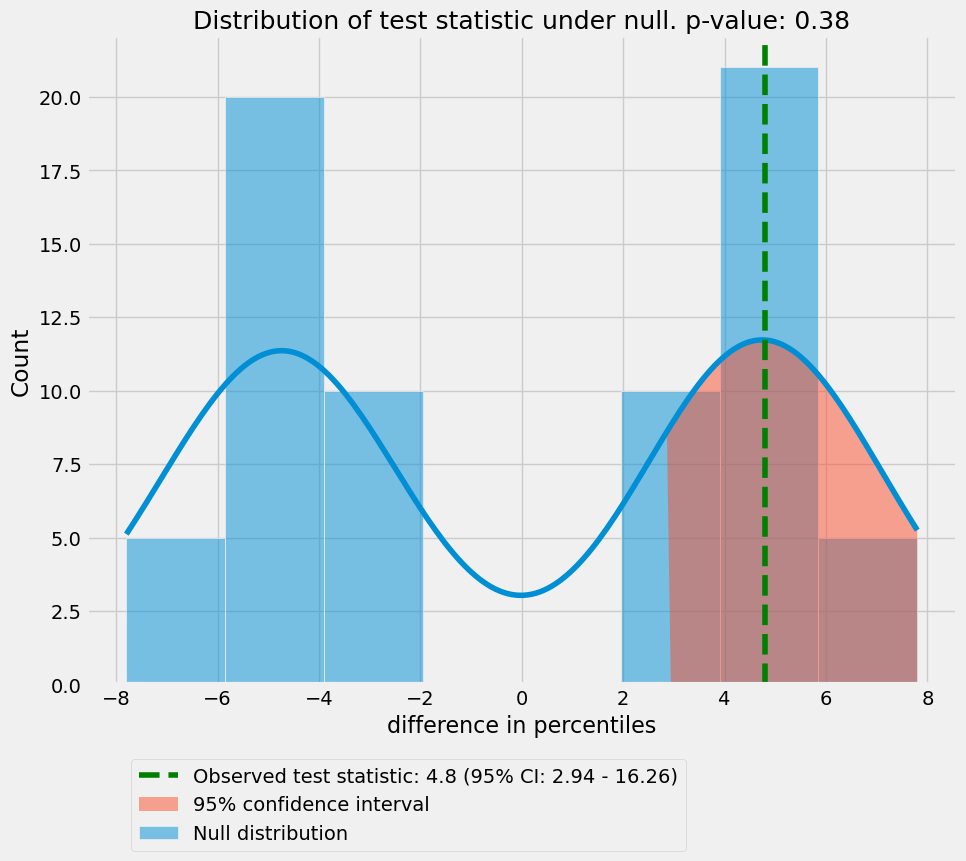

In [197]:
test_run_median.experimental_analysis(df=df, 
                               sharp_null_type='additive', 
                               sharp_null_value=0, 
                               test_statistic={'function': 'difference_in_percentiles', 'params': {'quantile': 0.9}}, 
                               treatment_assignment_probability=0.5, 
                               outcome_column_name='y', 
                               treatment_column_name='d', 
                               treatment_name=1, 
                               control_name=0, 
                               num_permutations=1000, 
                               alternative='two-sided', 
                               confidence=0.95, 
                               sample_with_replacement=True,
                              )

In [140]:
np.percentile(test_run.df_sims['test_statistic'].values, 100 * (1 - 0.05 / 2.0))

4.7749999999999915

In [141]:
np.percentile(test_run.df_sims['test_statistic'].values, 100 * (0.05 / 2.0))

-4.775

In [142]:
test_run.ci[0]

-2.7749999999999915

In [143]:
np.full_like(test_run.ci[0], -np.inf)

array(-inf)

In [127]:
# Pivotal on mean
low_mean_pivot = 2 * test_run.observed_test_statistic - np.percentile(test_run.df_sims['test_statistic'].values, 100 * (1 - 0.05 / 2.0))
high_mean_pivot = 2 * test_run.observed_test_statistic - np.percentile(test_run.df_sims['test_statistic'].values, 100 * (0.05 / 2.0))

In [128]:
low_mean_pivot

-2.7749999999999915

In [129]:
high_mean_pivot

6.775

In [153]:
confidence = 0.95
df_ = test_run.df_sims.copy()
df_ = df_.query("permutation != -1")

In [154]:
alternative = 'two-sided'

In [155]:
if alternative == 'two-sided':
    alpha = ((1 - confidence)) / 2
else:
    alpha = 1 - confidence

In [156]:
alpha

0.025000000000000022

In [157]:
interval = alpha, 1 - alpha

In [158]:
interval

(0.025000000000000022, 0.975)

In [159]:
ci_low = np.percentile(df_['test_statistic'].values, interval[0]*100)

In [160]:
ci_low

-4.774999999999999

In [161]:
ci_high = np.percentile(df_['test_statistic'].values, interval[1]*100)

In [162]:
ci_high

4.7749999999999915

In [163]:
ci_low, ci_high = 2 * test_run.observed_test_statistic - ci_high, 2 * test_run.observed_test_statistic - ci_low

In [164]:
ci_low

-2.7749999999999915

In [165]:
ci_high

6.774999999999999

In [ ]:
        alpha = 1 - confidence
        df_ = self.df_sims.copy()
        df_ = df_.query("permutation != -1")
        
        if alternative == 'two-sided':
            alpha = ((1 - confidence)) / 2
        else:
            alpha = 1 - confidence
        
        interval = alpha, 1 - alpha
        
        # Calculate the percentiles
        ci_low = np.percentile(df_['test_statistic'].values, interval[0]*100)
        ci_high = np.percentile(df_['test_statistic'].values, interval[1]*100)
        
        ci_low, ci_high = 2 * df_['test_statistic'] - ci_high, 2 * df_['test_statistic'] - ci_low
        
        if alternative == 'less':
            ci_low = np.full_like(ci_low, -np.inf)
        elif alternative == 'greater':
            ci_high = np.full_like(ci_high, np.inf)
        
        ci_ = np.array([ci_low, ci_high])
        
        return ci_

In [206]:
ax.ax

<Axes: xlabel='test_statistic', ylabel='Density'>

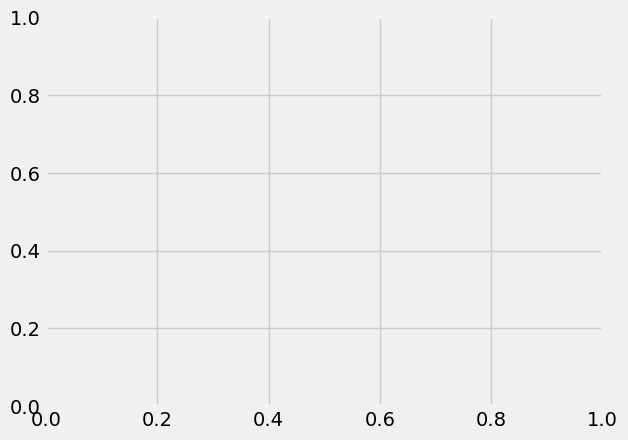

In [220]:
ax = plt.gca()

In [237]:
g.ax

<Axes: xlabel='test_statistic', ylabel='Density'>

IndexError: list index out of range

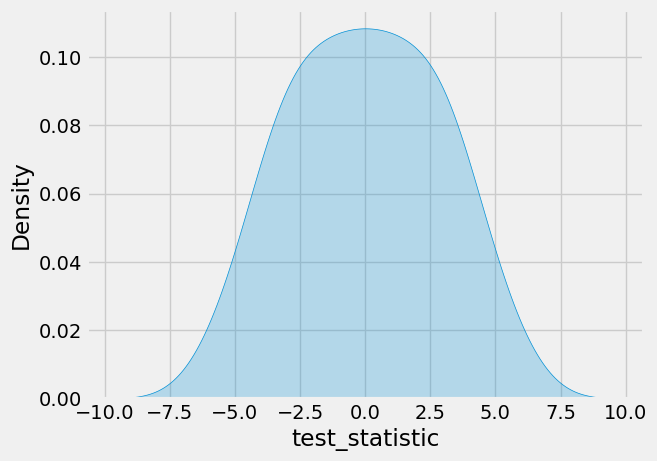

In [256]:
ax = sns.kdeplot(data=test_run.df_sims, x='test_statistic', fill=True)

kde_x, kde_y = ax.lines[0].get_data()

p0 = plt.axvline(x=test_run.observed_test_statistic, color='green')
p1 = plt.axvline(x=test_run.ci[0], color='#EF9A9A')
p2 = plt.axvline(x=test_run.ci[1], color='#EF9A9A')

ax.fill_between(kde_x, kde_y, where=(kde_x < test_run.ci[0]) | (kde_x > test_run.ci[1]) , 
                interpolate=True, color='#EF9A9A')

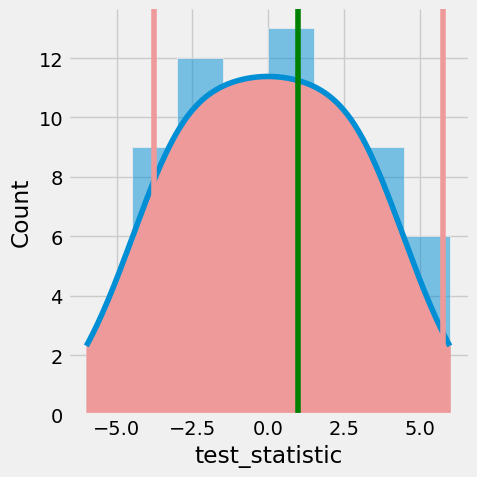

In [260]:
g = sns.displot(data=test_run.df_sims, x='test_statistic', kind='hist', fill=True, kde=True)

kde_x, kde_y = g.ax.lines[0].get_data()

g.ax.axvline(x=test_run.observed_test_statistic, color='green')
g.ax.axvline(x=test_run.ci[0], color='#EF9A9A')
g.ax.axvline(x=test_run.ci[1], color='#EF9A9A')

g.ax.fill_between(kde_x, kde_y, where=(kde_x > test_run.ci[0]) | (kde_x < test_run.ci[1]) , 
                interpolate=True, color='#EF9A9A')

# ax = g.ax
# ax = plt.gca()
# kde_x, kde_y = ax.lines[0].get_data()

# p0 = plt.axvline(x=test_run.observed_test_statistic, color='green')
# p1 = plt.axvline(x=test_run.ci[0], color='#EF9A9A')
# p2 = plt.axvline(x=test_run.ci[1], color='#EF9A9A')

# ax.fill_between(test_run.ci[0], test_run.ci[1])

# g.ax.fill_between(kde_x, kde_y, where=(kde_x < test_run.ci[0]) | (kde_x > test_run.ci[1]) , 
#                 interpolate=True, color='#EF9A9A')

In [252]:
kde_y

[0, 1]

In [229]:
print(g.axes[0,0])

Axes(0.195583,0.146833;0.762417x0.811167)


/var/folders/_w/zg400xvx6bzgj250lxvqktwr0000gn/T/ipykernel_23562/1075755712.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(a=test_run.df_sims['test_statistic'].values, hist=True, color='#388E3C')


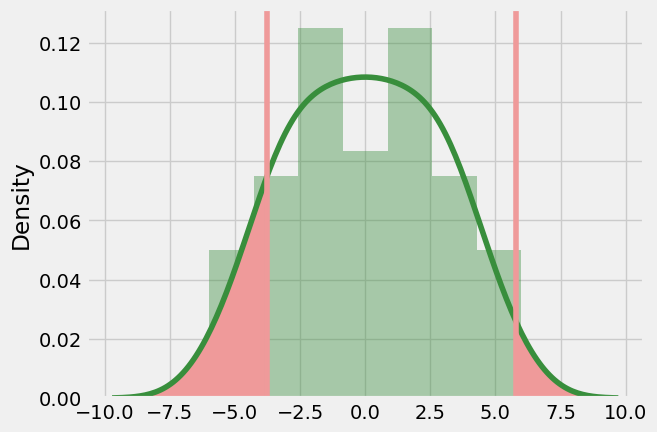

In [204]:
ax = sns.distplot(a=test_run.df_sims['test_statistic'].values, hist=True, color='#388E3C')
kde_x, kde_y = ax.lines[0].get_data()

#plotting the two lines
p1 = plt.axvline(x=test_run.ci[0], color='#EF9A9A')
p2 = plt.axvline(x=test_run.ci[1], color='#EF9A9A')


ax.fill_between(kde_x, kde_y, where=(kde_x < test_run.ci[0]) | (kde_x > test_run.ci[1]) , 
                interpolate=True, color='#EF9A9A')

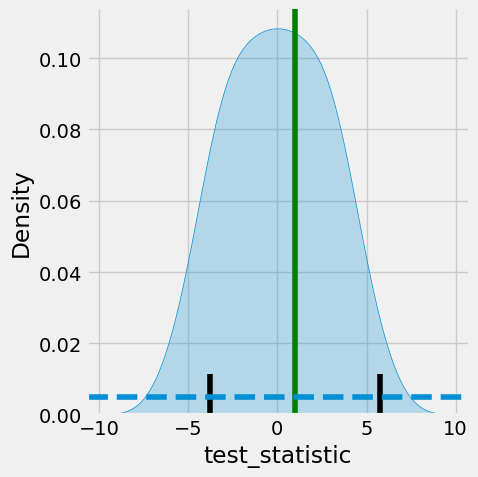

In [201]:
ax = sns.displot(data=test_run.df_sims, x='test_statistic', kind='kde', fill=True)
plt.axvline(x=test_run.observed_test_statistic, color='green', linestyle='-')
plt.axvline(x=test_run.ci[0], color='black', linestyle='-', ymax=0.1)
plt.axvline(x=test_run.ci[1], color='black', linestyle='-', ymax=0.1)
plt.axhline(y=0.005, xmin=test_run.ci[0], xmax=test_run.ci[1], linestyle='--')

In [167]:
test_run.df_sims['test_statistic'].nunique()

21

In [168]:
test_run.df_sims.shape

(70, 4)

In [169]:
test_run.df_sims

,permutation,test_statistic,rank_column,rank
0,0,1.0,1.0,60.0
1,1,2.0,2.0,46.0
2,2,3.0,3.0,30.0
3,3,3.5,3.5,22.0
4,4,4.5,4.5,12.0
5,5,-4.5,4.5,12.0
6,6,-3.5,3.5,22.0
7,7,-3.0,3.0,30.0
8,8,-2.0,2.0,46.0
9,9,-2.5,2.5,34.0


In [29]:
test_run.df_sims['test_statistic'].unique()

array([-1.        ,  3.42857143,  4.5       , -4.        , -3.2       ,
       -2.13333333, -0.5       , -2.66666667,  4.8       , -0.53333333,
        6.66666667,  5.33333333,  3.        ,  2.66666667, -1.14285714,
        2.5       , -3.5       , -3.        , -3.73333333,  0.        ,
        2.        , -6.        , -0.66666667, -2.5       ,  1.        ,
        2.13333333,  3.5       , -3.33333333, -4.26666667, -5.71428571,
        5.5       , -2.        , -1.06666667, -4.8       ,  1.6       ,
        4.        , -6.4       ,  4.8       , -6.66666667, -9.14285714,
       -1.06666667, -5.86666667, -1.6       , -0.66666667,  2.28571429,
       -1.5       ,  0.53333333,  4.26666667,  3.33333333,  0.66666667,
        0.53333333, -5.33333333, -0.53333333, -3.33333333,  3.2       ,
        1.06666667, -3.73333333, -3.42857143,  1.5       ,  6.4       ,
       -4.5       ,  3.73333333,  6.        ,  4.66666667, -1.33333333,
        5.71428571, -2.28571429,  1.06666667,  2.66666667,      

In [30]:
test_run.df_sims['permutation'].min()

0

In [31]:
test_run.df_sims.query("test_statistic==1")

,permutation,test_statistic,rank_column,rank
32,32,1.0,1.0,817.0
95,95,1.0,1.0,817.0
101,101,1.0,1.0,817.0
192,192,1.0,1.0,817.0
194,194,1.0,1.0,817.0
242,242,1.0,1.0,817.0
281,281,1.0,1.0,817.0
328,328,1.0,1.0,817.0
336,336,1.0,1.0,817.0
381,381,1.0,1.0,817.0


In [32]:
test_run.df_sims.query("test_statistic==-1")

,permutation,test_statistic,rank_column,rank
0,0,-1.0,1.0,817.0
9,9,-1.0,1.0,817.0
58,58,-1.0,1.0,817.0
74,74,-1.0,1.0,817.0
109,109,-1.0,1.0,817.0
196,196,-1.0,1.0,817.0
198,198,-1.0,1.0,817.0
388,388,-1.0,1.0,817.0
403,403,-1.0,1.0,817.0
408,408,-1.0,1.0,817.0


In [33]:
# So why is this different?
test_run.df_sims['rank'].nunique()

42

In [34]:
 0.8571429 * 70

60.000003

In [35]:
test_run.df_sims['rank_column'].nunique()

42

In [36]:
8056/10000

0.8056

In [37]:
# So I think the problem is the permutations are being correctly labeled.  
test_run.df_sims['permutation'].max()

999

In [38]:
test_run.df_sims.head()

,permutation,test_statistic,rank_column,rank
0,0,-1.000000,1.000000,817.0
1,1,3.428571,3.428571,302.0
2,2,4.500000,4.500000,172.0
3,3,-4.000000,4.000000,201.0
4,4,4.500000,4.500000,172.0


In [40]:
test_run.df_sims.query("test_statistic==@test_run.observed_test_statistic")['rank']

32     817.0
95     817.0
101    817.0
192    817.0
194    817.0
242    817.0
281    817.0
328    817.0
336    817.0
381    817.0
416    817.0
425    817.0
498    817.0
579    817.0
591    817.0
693    817.0
718    817.0
724    817.0
727    817.0
730    817.0
811    817.0
817    817.0
829    817.0
885    817.0
926    817.0
928    817.0
963    817.0
984    817.0
Name: rank, dtype: float64

In [41]:
817/1000

0.817

In [42]:
df_from_r = pd.read_csv('../../../data/r_output_ri.csv')

In [43]:
df_from_r.head()

,Unnamed: 0,est_sim,est_obs,term
0,1,-1.0,1,Custom Test Statistic
1,2,-2.0,1,Custom Test Statistic
2,3,-3.0,1,Custom Test Statistic
3,4,-3.5,1,Custom Test Statistic
4,5,-4.5,1,Custom Test Statistic


In [44]:
df_from_r.columns = ['permutation', 'test_statistic', 'est_obs', 'term']

In [45]:
df_from_r.head()

,permutation,test_statistic,est_obs,term
0,1,-1.0,1,Custom Test Statistic
1,2,-2.0,1,Custom Test Statistic
2,3,-3.0,1,Custom Test Statistic
3,4,-3.5,1,Custom Test Statistic
4,5,-4.5,1,Custom Test Statistic


In [46]:
def p_value_test(df_sims, alternative, observed_test_statistic):

   #  df_ = self.df_sims.copy()

    if not observed_test_statistic in df_sims['test_statistic'].values:
        add_row = pd.DataFrame({"permutation": [-1], "test_statistic": observed_test_statistic})
        df_sims = pd.concat([add_row, df_sims])
        observed_perm = -1
    else:
        observed_perm = df_sims.loc[(df_sims['test_statistic'] == observed_test_statistic)]['permutation'].values[0]

    if alternative == 'two-sided':
        df_sims['rank_column'] = np.abs(df_sims['test_statistic'])
    else:
        df_sims['rank_column'] = df_sims['test_statistic']

    df_sims['rank'] = df_sims['rank_column'].rank(method='max', ascending=False)

    p_value = df_sims.query("permutation==@observed_perm")['rank'].values[0] / df_sims.shape[0]

    return p_value

In [47]:
p_value_test(df_sims=df_from_r, alternative='two-sided', observed_test_statistic=1.0)

0.8571428571428571

In [48]:
# Ok so this works. This p-value is correct. the problem is in deciding on the number of simulations to run

In [49]:
import math
import itertools

In [50]:
math.comb(8, 4)

70

In [51]:
df

,name,d,y,y0,y1,id_unit
0,Andy,1,10,NaN,10.0,1
1,Ben,1,5,NaN,5.0,2
2,Chad,1,16,NaN,16.0,3
3,Daniel,1,3,NaN,3.0,4
4,Edith,0,5,5.0,NaN,5
5,Frank,0,7,7.0,NaN,6
6,George,0,8,8.0,NaN,7
7,Hank,0,10,10.0,NaN,8


In [52]:
combs_ = itertools.combinations(df['id_unit'].values, 4)

In [53]:
combs_ = list(combs_)

In [54]:
len(combs_)

70

In [55]:
# combs_

In [56]:
# So this is all the combinations
math.comb(1000, int(1000/2))

270288240945436569515614693625975275496152008446548287007392875106625428705522193898612483924502370165362606085021546104802209750050679917549894219699518475423665484263751733356162464079737887344364574161119497604571044985756287880514600994219426752366915856603136862602484428109296905863799821216320

In [57]:
int(10/2)

5

In [58]:
df.head()

,name,d,y,y0,y1,id_unit
0,Andy,1,10,NaN,10.0,1
1,Ben,1,5,NaN,5.0,2
2,Chad,1,16,NaN,16.0,3
3,Daniel,1,3,NaN,3.0,4
4,Edith,0,5,5.0,NaN,5


In [59]:
assignments_ = []

In [60]:
# This is not efficient. Here's a potential solution
# step 1: return assignments as a tuple
# step 2: has tuple
# step 3: save tuple and hash in a dictionary. The keys are the hash, the values are the tuples
# step 4: repeat until there are num_sims hashes in the dictionary. These will all be unique permutations
# step 0: Only do this if the number of possible assignment combinations is huge. Otherwise, default to using every possible assignment combination (how do we handle odd assignment probabilities?)
# for x in range(100):
#     assignment_ = stats.binom.rvs(n=1, p=0.5, size=df['id_unit'].nunique())
#     if assignment_ not in assignments_:
#         assignments_.append(assignment_)

In [ ]:
def make_hypothetical_assignments(df_, treatment_assignment_probability):
    # This is too simple. We need to actually sample from the space of assignment vectors without replacement. 
    assert treatment_assignment_probability > 0 and treatment_assignment_probability < 1, "Treatment assignment probabilities must be great than 0 and less than 1. Received {0}".format(treatment_assignment_probability)

    # set the random seed
    np.random.seed()

    df_['ri_in_treatment'] = stats.binom.rvs(n=1, p=treatment_assignment_probability, size=df_.shape[0])

    return df_

In [64]:
def memoized_hypothetical_assignment(size, treatment_assignment_probability, num_perms):
    assert treatment_assignment_probability > 0 and treatment_assignment_probability < 1, "Treatment assignment probabilities must be great than 0 and less than 1. Received {0}".format(treatment_assignment_probability)
    
    # set the random seed
    np.random.seed()
    
    # Make assignment
    assignment_dict = {}
    # Ok so this isn't it. It will just keep going an going if there are no more possible permutations, so we need to be careful with this implementation
    
    while len(assignment_dict) < num_perms:
        assignment_tuple = tuple(stats.binom.rvs(n=1, p=treatment_assignment_probability, size=size))
        hashed_key = hash(assignment_tuple)
        if hashed_key not in assignment_dict:
            assignment_dict[hashed_key] = assignment_tuple
    
    return assignment_dict
        

In [100]:
size = 8
treatment_probability = 0.5

In [102]:
all_combs = list(itertools.combinations(list(range(size)), int(size*treatment_probability)))

In [104]:
len(all_combs)

70

In [134]:
hypothetical_assignments = {}
for i, comb in enumerate(all_combs):
    assignment_vector = np.zeros(size)
    assignment_vector[list(comb)] = 1
    hypothetical_assignments[i] = assignment_vector

In [110]:
hypothetical_assignments

{0: array([1., 1., 1., 1., 0., 0., 0., 0.]),
 1: array([1., 1., 1., 0., 1., 0., 0., 0.]),
 2: array([1., 1., 1., 0., 0., 1., 0., 0.]),
 3: array([1., 1., 1., 0., 0., 0., 1., 0.]),
 4: array([1., 1., 1., 0., 0., 0., 0., 1.]),
 5: array([1., 1., 0., 1., 1., 0., 0., 0.]),
 6: array([1., 1., 0., 1., 0., 1., 0., 0.]),
 7: array([1., 1., 0., 1., 0., 0., 1., 0.]),
 8: array([1., 1., 0., 1., 0., 0., 0., 1.]),
 9: array([1., 1., 0., 0., 1., 1., 0., 0.]),
 10: array([1., 1., 0., 0., 1., 0., 1., 0.]),
 11: array([1., 1., 0., 0., 1., 0., 0., 1.]),
 12: array([1., 1., 0., 0., 0., 1., 1., 0.]),
 13: array([1., 1., 0., 0., 0., 1., 0., 1.]),
 14: array([1., 1., 0., 0., 0., 0., 1., 1.]),
 15: array([1., 0., 1., 1., 1., 0., 0., 0.]),
 16: array([1., 0., 1., 1., 0., 1., 0., 0.]),
 17: array([1., 0., 1., 1., 0., 0., 1., 0.]),
 18: array([1., 0., 1., 1., 0., 0., 0., 1.]),
 19: array([1., 0., 1., 0., 1., 1., 0., 0.]),
 20: array([1., 0., 1., 0., 1., 0., 1., 0.]),
 21: array([1., 0., 1., 0., 1., 0., 0., 1.])

In [111]:
len(hypothetical_assignments)

70

In [96]:
all_combs = list(itertools.combinations(df['id_unit'].values, 4))

In [ ]:
l = [3,4,7,9]
m = np.zeros(max(l)+1)
m[l] = 1

In [98]:
assignments_array = np.zeros(df['id_unit'].nunique())

In [99]:
assignments_array

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [145]:
def get_all_combinations(size, treatment_probability):
    all_combs = list(itertools.combinations(list(range(size)), int(size*treatment_probability)))
    hypothetical_assignments = {}
    for i, comb in enumerate(all_combs):
        assignment_vector = np.zeros(size)
        assignment_vector[list(comb)] = 1
        hypothetical_assignments[i] = tuple(assignment_vector)
    
    return hypothetical_assignments

In [146]:
def make_hypothetical_assignment(size, treatment_assignment_probability, num_perms=1000):
    assert treatment_assignment_probability > 0 and treatment_assignment_probability < 1, "Treatment assignment probabilities must be great than 0 and less than 1. Received {0}".format(treatment_assignment_probability)
    
    # set the random seed
    np.random.seed()
    
    try:
        n_combs = math.comb(size, int(size*treatment_probability))
    except ValueError:
        n_combs = np.inf
    
    print(n_combs)
    if n_combs <= num_perms:
        print('this happened')
        # Just get all possible assignment combinations
        assignment_dict = get_all_combinations(size, treatment_probability)
    else:
        assignment_dict = {}
        while len(assignment_dict) < num_perms: # I'm a little worried that this is going to run forever
            assignment_tuple = tuple(stats.binom.rvs(n=1, p=treatment_assignment_probability, size=size))
            hashed_key = hash(assignment_tuple)
            if hashed_key not in assignment_dict:
                assignment_dict[hashed_key] = assignment_tuple
    
    return assignment_dict

In [ ]:
# Now we need a function to calculate the test statistic
# Effectively this needs to replace
# def make_hypothetical_assignments(df_, treatment_assignment_probability):
#     # This is too simple. We need to actually sample from the space of assignment vectors without replacement. 
#     assert treatment_assignment_probability > 0 and treatment_assignment_probability < 1, "Treatment assignment probabilities must be great than 0 and less than 1. Received {0}".format(treatment_assignment_probability)

#     # set the random seed
#     np.random.seed()

#     df_['ri_in_treatment'] = stats.binom.rvs(n=1, p=treatment_assignment_probability, size=df_.shape[0])

#     return df_
# AND
# def run_randomization_inference(self, df, test_statistic_function, treatment_assignment_probability):

#     df_ = self.make_hypothetical_assignments(df_=df, treatment_assignment_probability=treatment_assignment_probability)

#     stat_ = test_statistic_function(df=df_, outcome_col='outcome_sharp_null', treatment_col='ri_in_treatment', treatment_name=1, control_name=0)

#     return stat_
def calculate_test_statistic(df, test_statistic_function, assignment_dict):
    sim_dict = {}
    for i, assignment_tuple in tqdm(enumerate(assignment_dict.values())):
        df_['ri_in_treatment'] = assignment_tuple
        stat_ = test_statistic_function(df=df_, outcome_col='outcome_sharp_null', treatment_col='ri_in_treatment', treatment_name=1, control_name=0)
        sim_dict[i] = stat_
    
    return sim_dict

In [147]:
test_assignment_dict = make_hypothetical_assignment(size=df.shape[0], treatment_assignment_probability=0.5, num_perms=700)

70
this happened


In [148]:
len(test_assignment_dict)

70

In [149]:
assignments_list = list(test_assignment_dict.values())

In [150]:
len(assignments_list)

70

In [151]:
assigmments_list

[(1, 0, 1, 1, 1, 0, 0, 0),
 (0, 1, 1, 1, 1, 0, 0, 0),
 (0, 1, 0, 0, 1, 1, 0, 0),
 (1, 0, 0, 0, 0, 0, 0, 0),
 (1, 1, 0, 0, 0, 0, 0, 0),
 (0, 1, 0, 1, 0, 1, 1, 0),
 (1, 0, 1, 0, 1, 1, 1, 0),
 (0, 1, 1, 0, 0, 1, 1, 1),
 (0, 1, 0, 1, 1, 0, 1, 0),
 (0, 0, 0, 0, 0, 0, 1, 0),
 (1, 1, 0, 0, 0, 1, 0, 1),
 (1, 1, 1, 0, 1, 0, 0, 0),
 (1, 1, 1, 0, 1, 1, 1, 1),
 (1, 1, 0, 1, 1, 0, 1, 1),
 (0, 0, 1, 0, 1, 1, 1, 0),
 (0, 0, 1, 1, 0, 1, 1, 0),
 (0, 0, 1, 0, 1, 0, 0, 1),
 (0, 0, 0, 1, 1, 0, 1, 1),
 (0, 1, 1, 1, 0, 1, 0, 0),
 (1, 0, 0, 0, 1, 0, 0, 1),
 (1, 1, 0, 1, 1, 1, 1, 1),
 (0, 1, 0, 1, 0, 0, 1, 1),
 (1, 0, 0, 0, 0, 1, 0, 0),
 (1, 0, 1, 0, 0, 0, 1, 0),
 (0, 0, 1, 0, 0, 0, 1, 1),
 (0, 0, 1, 1, 1, 1, 0, 1),
 (1, 1, 1, 1, 1, 1, 0, 1),
 (1, 0, 0, 1, 1, 1, 1, 1),
 (1, 0, 1, 0, 1, 1, 0, 1),
 (0, 1, 0, 0, 1, 1, 0, 1),
 (0, 0, 1, 0, 0, 0, 1, 0),
 (0, 1, 1, 0, 0, 0, 1, 1),
 (0, 0, 0, 0, 1, 0, 1, 1),
 (1, 0, 0, 1, 1, 0, 1, 1),
 (0, 0, 0, 1, 0, 0, 1, 1),
 (0, 1, 1, 1, 1, 0, 1, 1),
 (1, 1, 0, 1, 0, 1, 1, 0),
 

In [152]:
assignments_list[0]

(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0)

In [153]:
len(set(assignments_list))

70

In [77]:
# Nice, they are all unique.  All we need to do now if compute the test statistic based on these assignments :) 
# We can add a check in here to just get the total combinations if the total is small enough (how small?)

In [78]:
math.comb(8, 4)

70

In [79]:
test_assignment_dict = memoized_hypothetical_assignment(size=df.shape[0], treatment_assignment_probability=0.5, num_perms=70)

In [80]:
len(test_assignment_dict)

70

In [83]:
math.comb(8, 4)

70

In [92]:
math.comb(100000, 50000)

ValueError: Exceeds the limit (4300) for integer string conversion; use sys.set_int_max_str_digits() to increase the limit

In [91]:
math.comb(8, int(8*0.5))

70